# Best time to release review after tech event

In [21]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import matplotlib.pyplot as plt

In [16]:
PATH_YT_METADATA = 'data/yt_metadata_en.jsonl'
ITEMS = ['iphone x', 'iphone 7', 'iphone 6', 'galaxy s9', 'galaxy note 9', 'galaxy fold']
RELEASE_DATES = {
    'iphone x': '2017-11-03',
    'iphone 7': '2016-09-16',
    'iphone 6': '2014-09-19',
    'galaxy s9': '2018-03-16',
    'galaxy note 9': '2018-08-24',
    'galaxy fold': '2019-02-01'
}

In [3]:
items_dfs = {k : [] for k in ITEMS}

In [4]:
# filter metadata
total_rows = 72924794
chunksize = 100000
for df_json in tqdm(pd.read_json(PATH_YT_METADATA, compression="infer", lines=True, chunksize=chunksize), desc='Loading data', total=total_rows/chunksize):
    df_json.drop(["description", "crawl_date", "display_id", "tags"], inplace=True, axis=1)
    df_json = df_json[df_json['categories'].isin(['Science & Technology', 'Education', 'Entertainment'])]
    df_json.drop(["categories"], inplace=True, axis=1)
    for item in ITEMS:
        df_item = df_json[df_json['title'].str.lower().str.contains(item)]
        df_item["upload_date"] = pd.to_datetime(df_item["upload_date"])
        df_item = df_item[(df_item['upload_date'] >= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') - datetime.timedelta(days=180)) & (df_item['upload_date'] <= datetime.datetime.strptime(RELEASE_DATES[item], '%Y-%m-%d') + datetime.timedelta(days=180))]
        if len(df_item) > 0:
            items_dfs[item].append(df_item)
# yt_metadata.to_pickle(PATH_YT_TECH_METADATA,compression='gzip')

Loading data:   0%|          | 0/729.24794 [00:00<?, ?it/s]

/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_1771/2882069087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json.drop(["categories"], inplace=True, axis=1)
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_1771/2882069087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_item["upload_date"] = pd.to_datetime(df_item["upload_date"])
/var/folders/zj/sr110gkn1vz4qf70llfwlh8c0000gn/T/ipykernel_1771/2882069087.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [5]:
items_dfs = {k : pd.concat(v) for k, v in items_dfs.items()}

In [32]:
import pickle
with open('data/yt_tech_metadata.pickle', 'wb') as f:
    pickle.dump(items_dfs, f)

In [6]:
for item in ITEMS:
    print(len(items_dfs[item]))

5388
4456
3856
3882
2293
596


In [33]:
def get_avg_views(df):
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # keep only 'view_count' and 'upload_date'
    df = df[["view_count", "upload_date"]]
    df = df.groupby("upload_date").sum()
    
    return df

In [34]:
def plot_views_per_day(df, item):
    plt.figure(figsize=(20,10))
    plt.bar(df.index, df["view_count"])
    plt.xlabel("Date")
    plt.ylabel("View Count")
    plt.title("{item} View Count Over Time".format(item=item))
    plt.show()

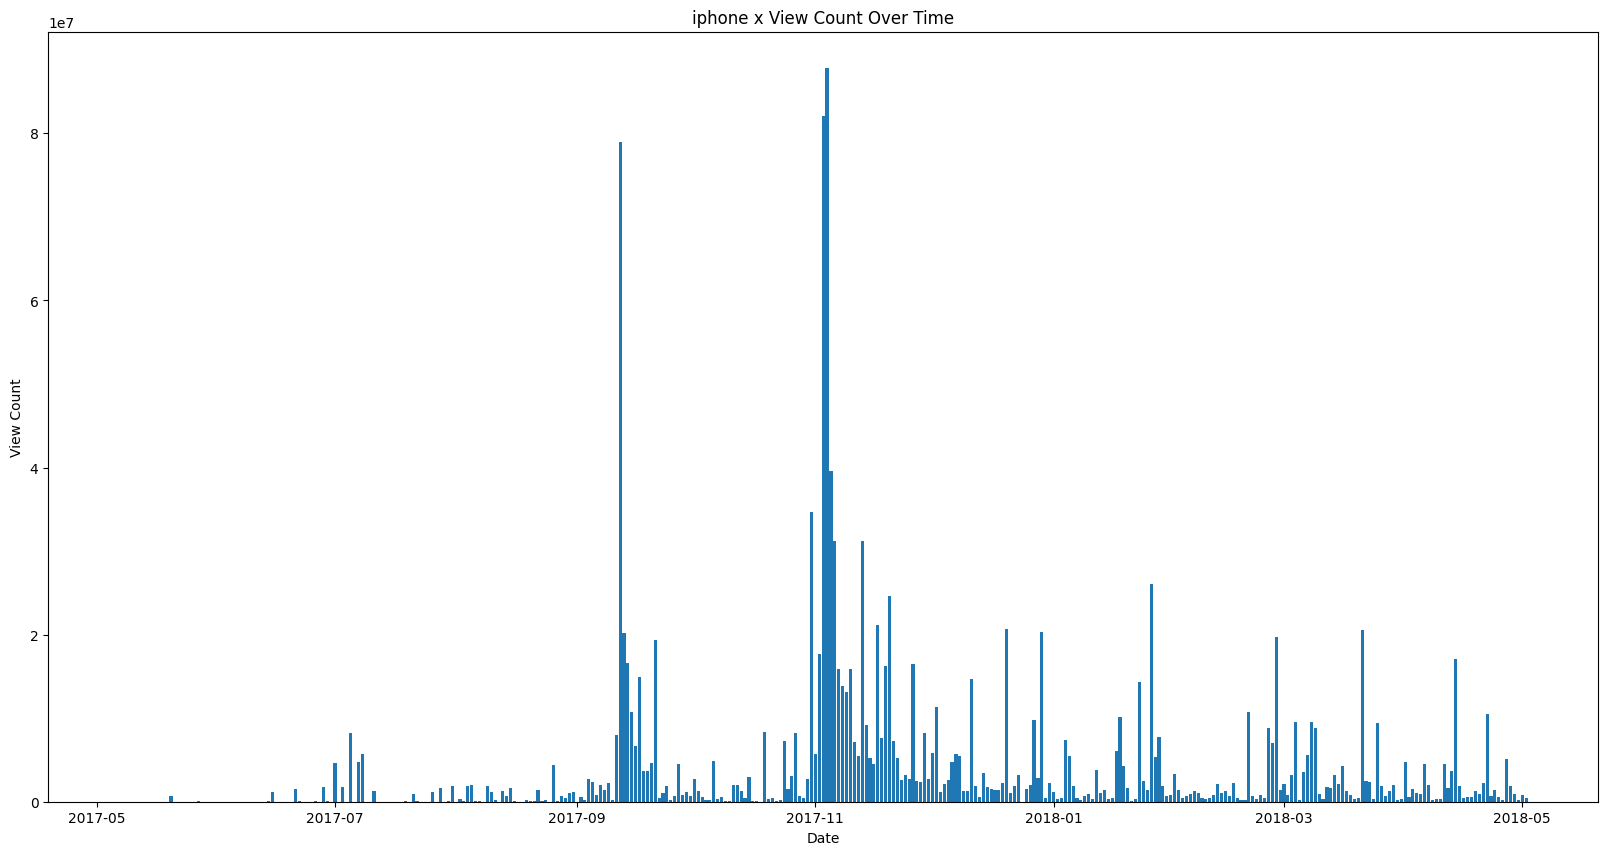

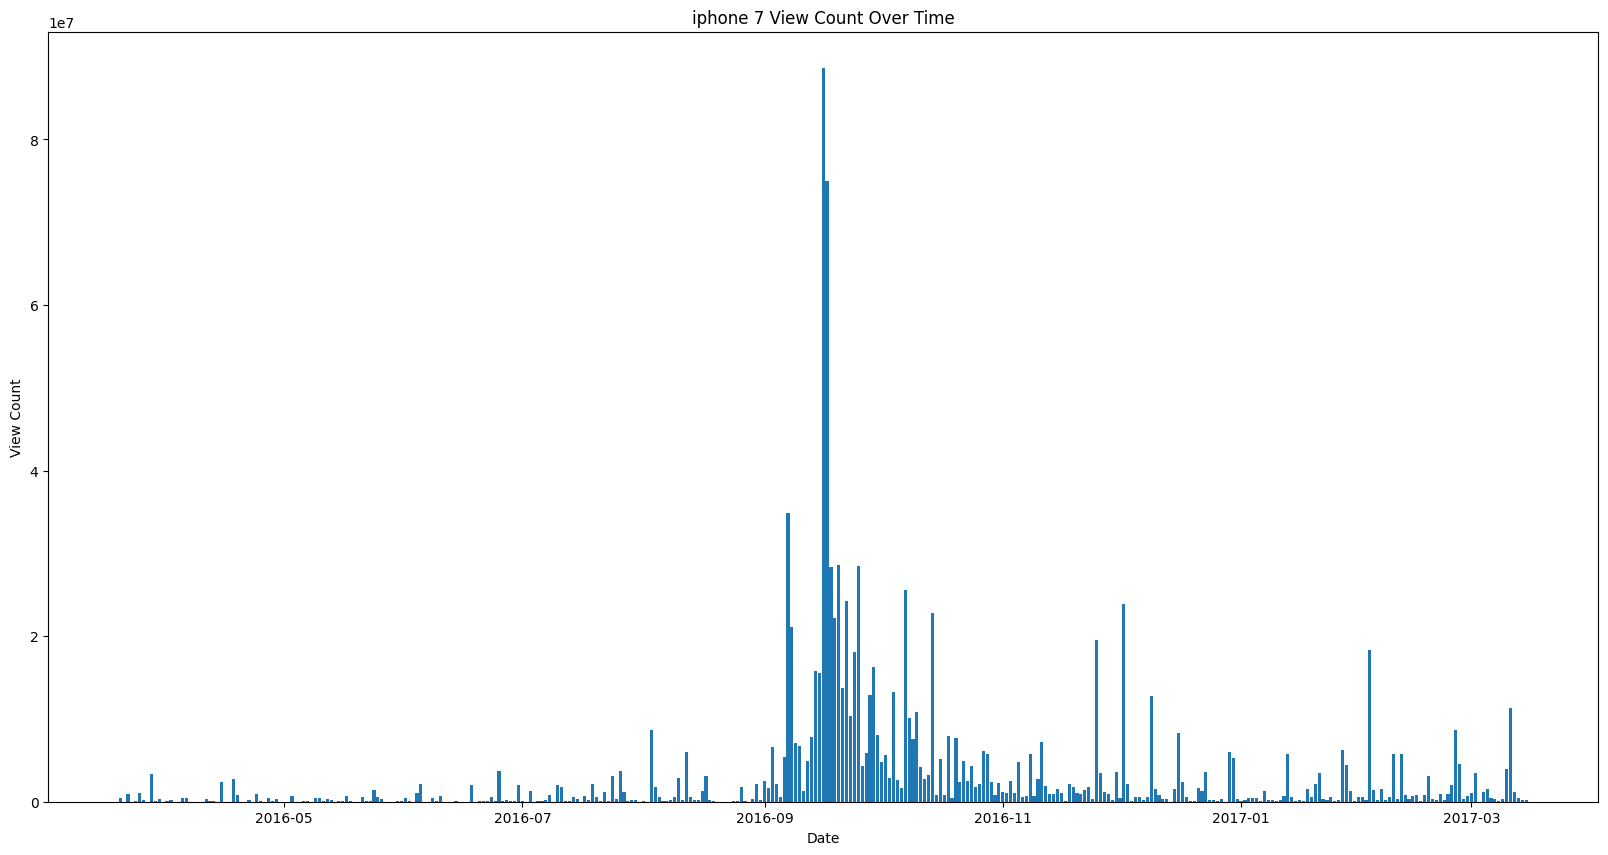

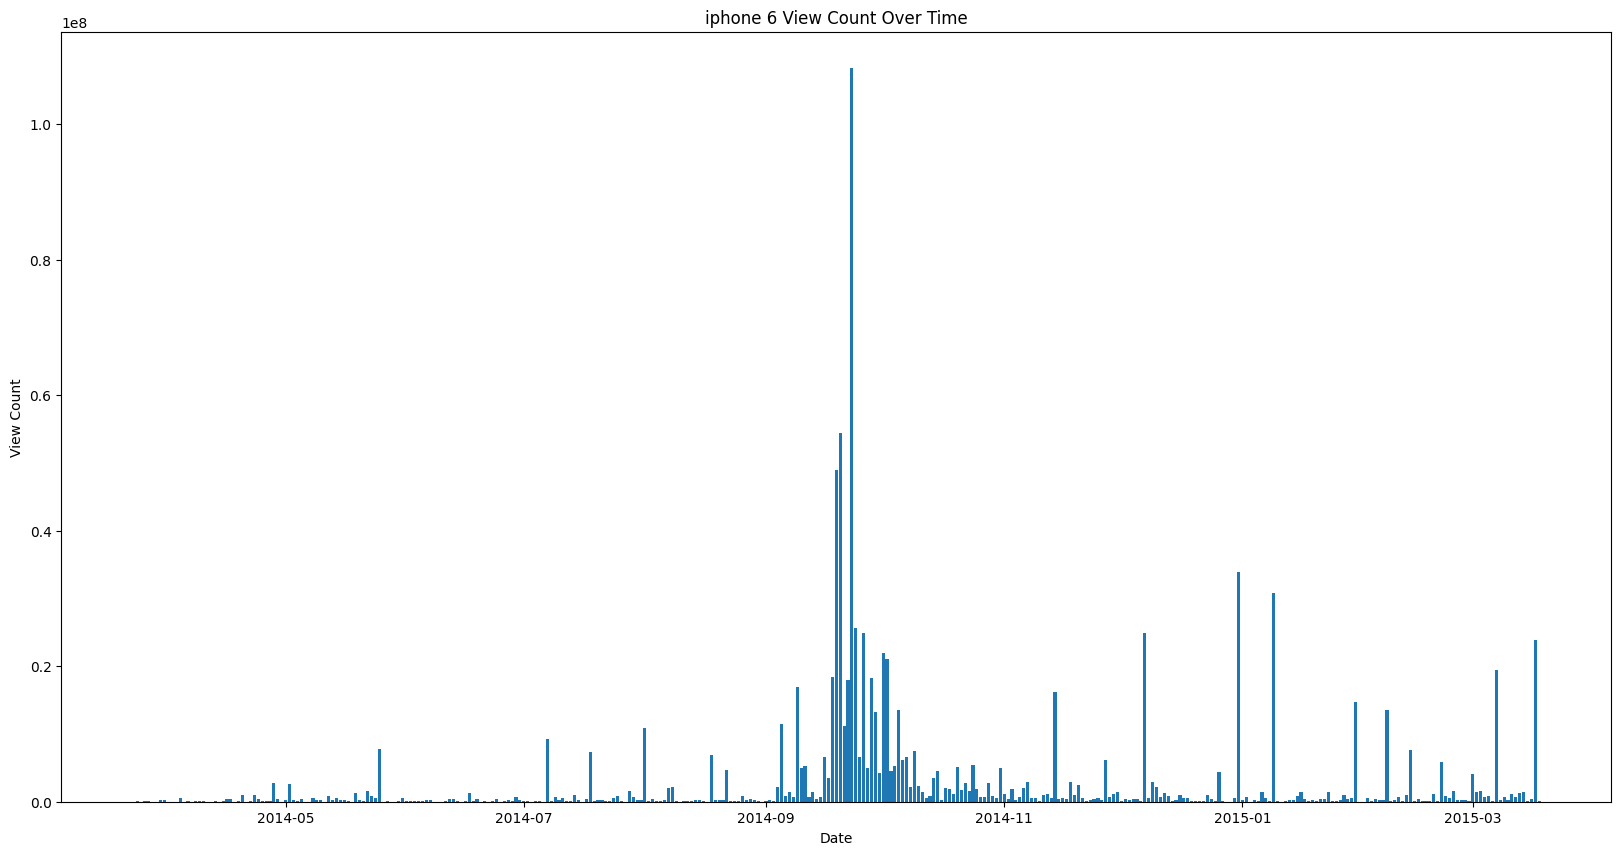

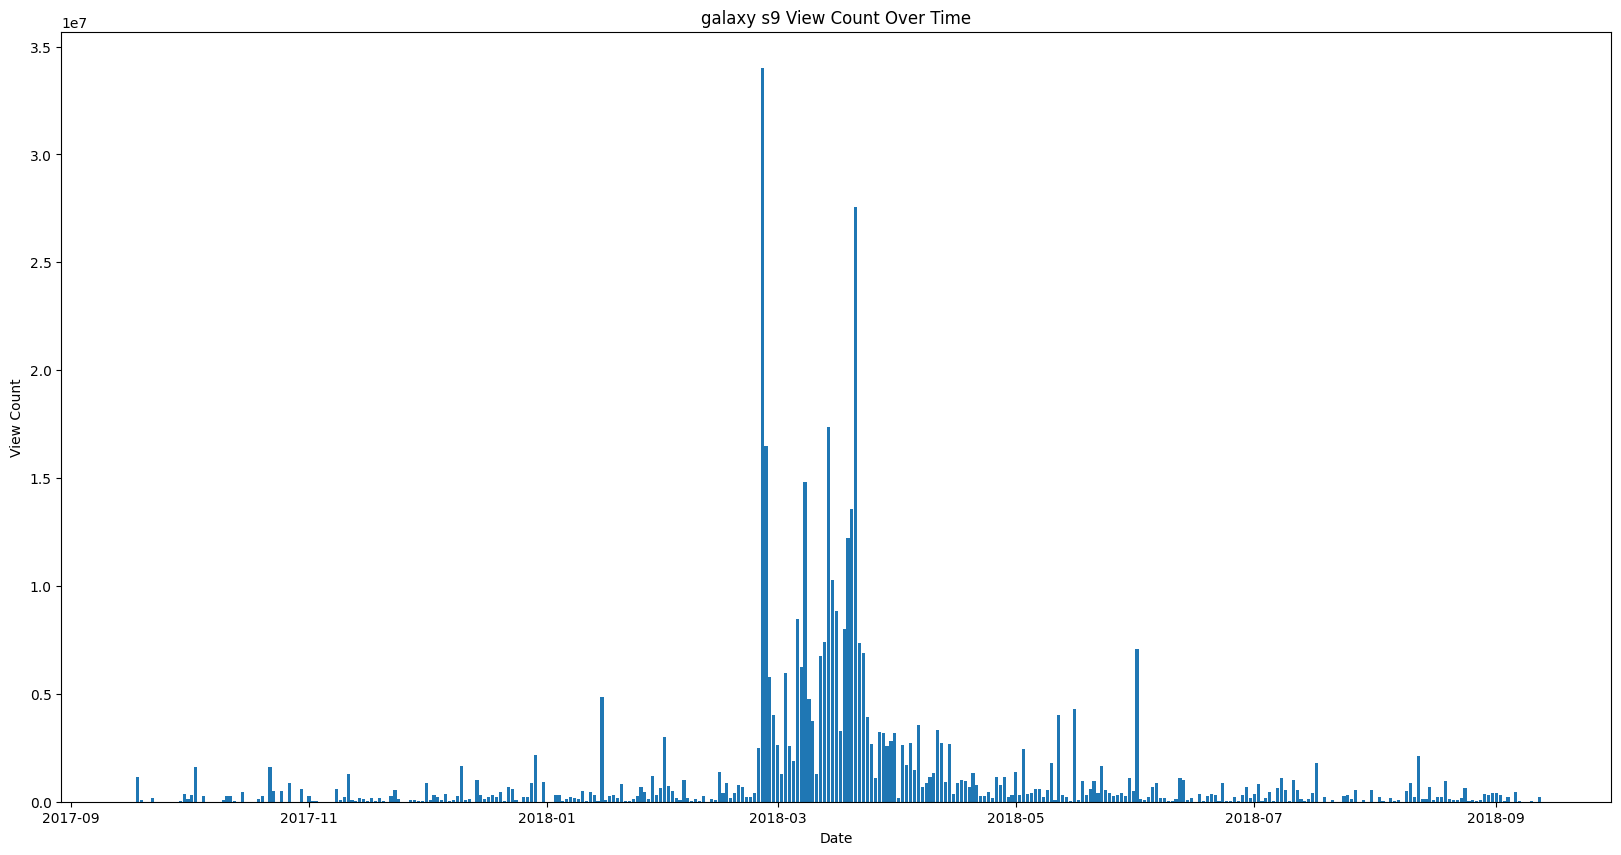

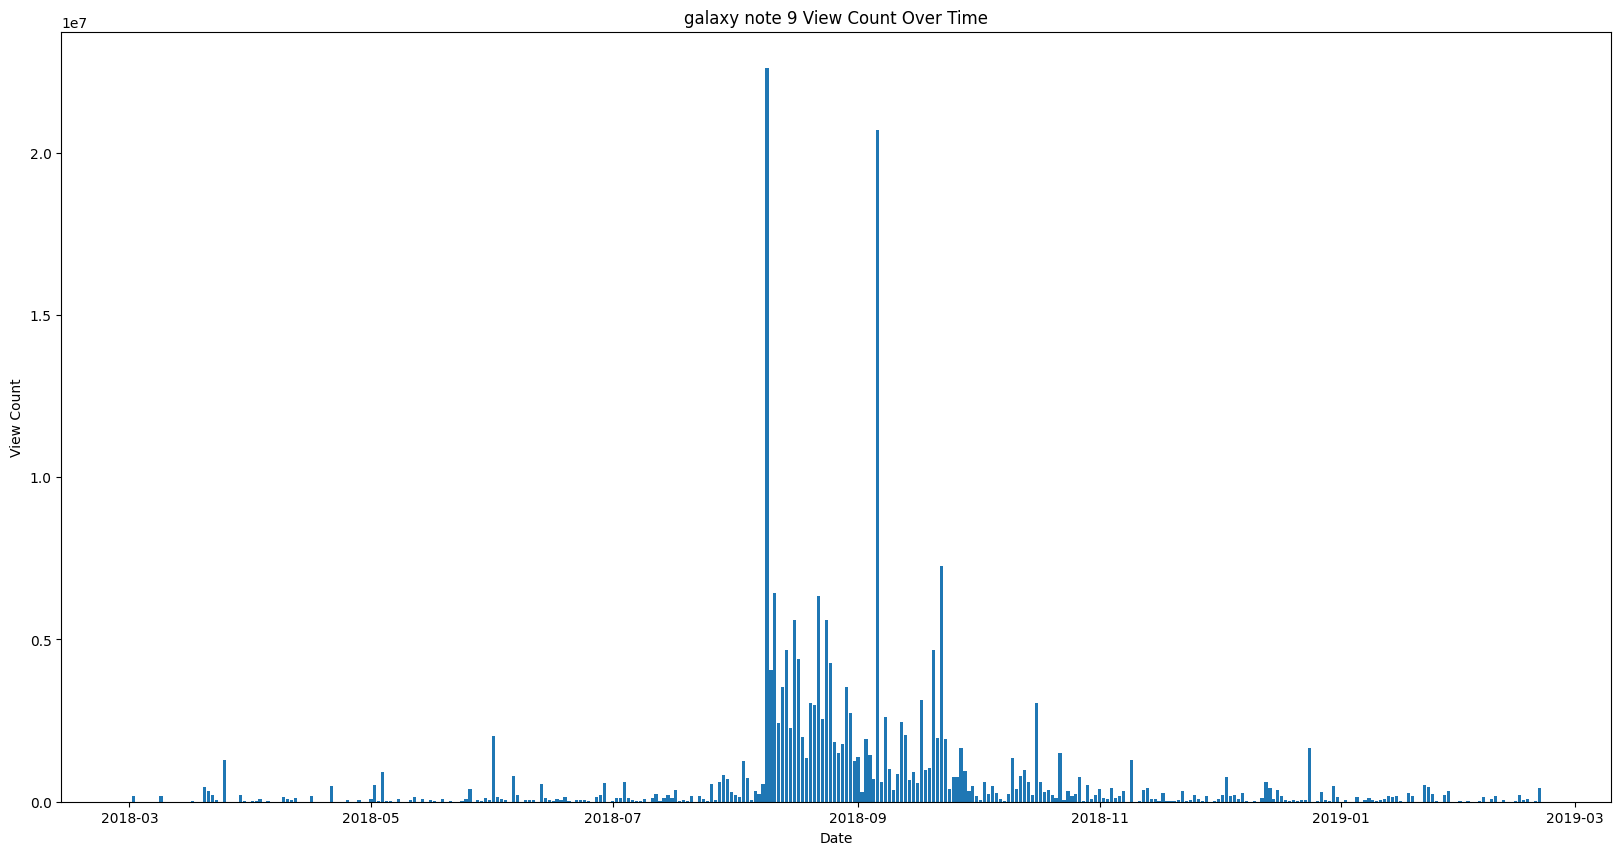

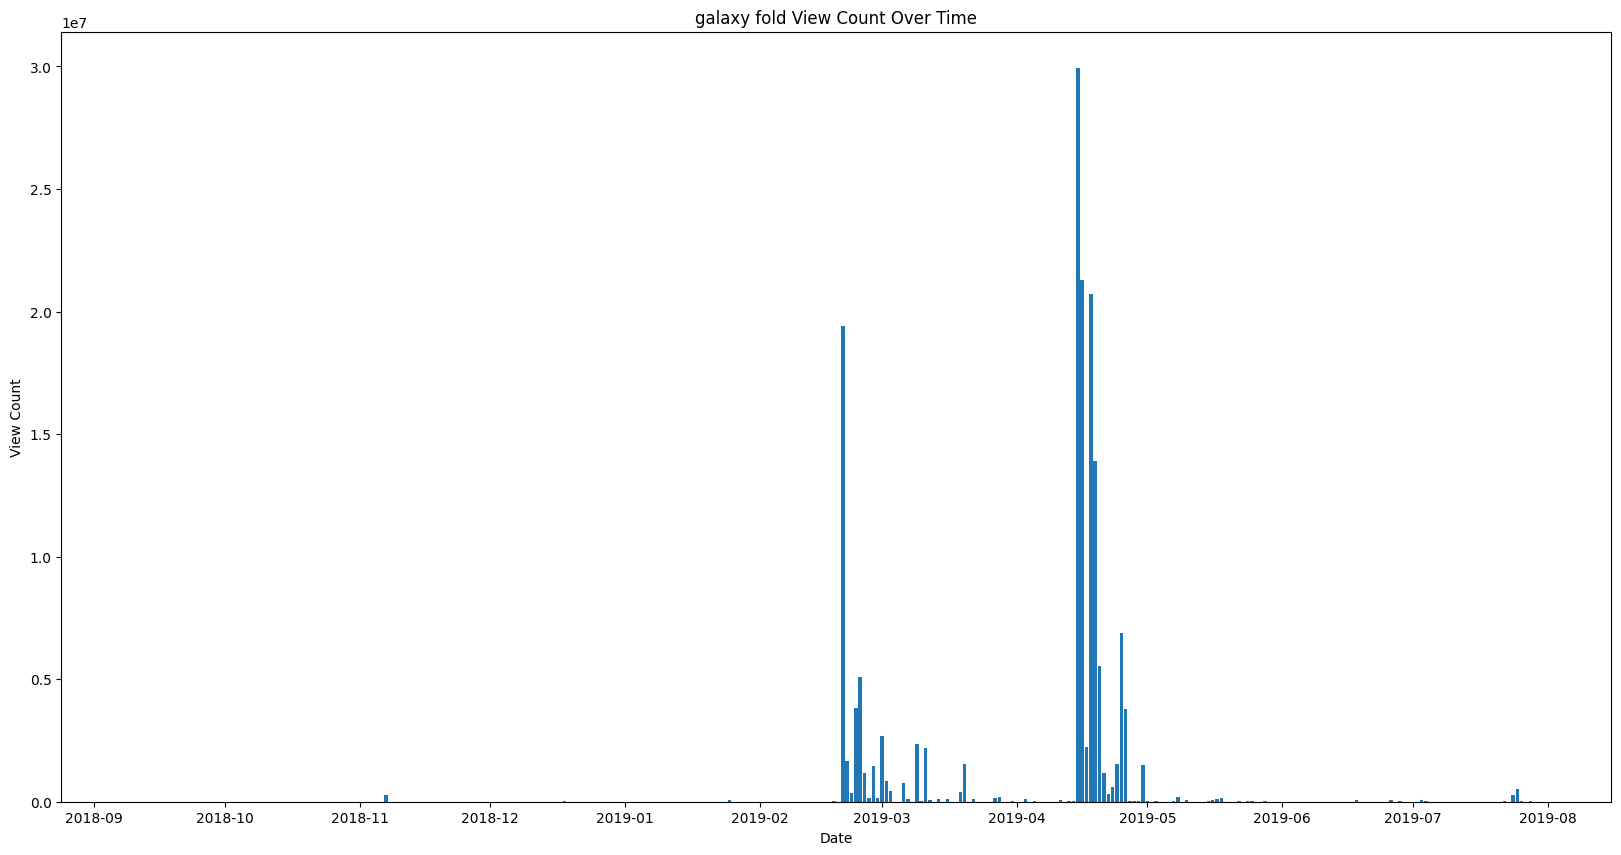

In [35]:
for item in ITEMS:
    df = get_avg_views(items_dfs[item])
    plot_views_per_day(df, item)

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from gensim import corpora, models
import gensim
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_lda_topics(df, num_topics, num_words):
    # tokenize words
    tokenizer = RegexpTokenizer(r'\w+')
    df["tokens"] = df["title"].apply(tokenizer.tokenize)
    
    # remove stop words
    stop_words = stopwords.words('english')
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in stop_words])
    
    # lemmatize words
    lemmatizer = WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    # remove words that appear only once
    all_tokens = sum(df["tokens"], [])
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    df["tokens"] = df["tokens"].apply(lambda x: [word for word in x if word not in tokens_once])
    
    # create dictionary and corpus
    dictionary = corpora.Dictionary(df["tokens"])
    corpus = [dictionary.doc2bow(text) for text in df["tokens"]]
    
    # create LDA model
    lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    
    # print topics
    print("LDA Topics:")
    for topic in lda.print_topics(num_words=num_words):
        print(topic)
    
    # visualize topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    return vis


In [ ]:
item = 'iphone x'
df = items_dfs[item]
vis = get_lda_topics(df, 5, 10)

In [ ]:
def tf_idf(tokens):
    """
    Given a list of tokens, compute the tf-idf coefficient for each token.
    :param tokens: list of titles split into tokens
    :return: dictionary of tf-idf coefficients
    """
    # create dictionary
    dictionary = corpora.Dictionary(tokens)
    
    # create corpus
    corpus = [dictionary.doc2bow(text) for text in tokens]
    
    # create tf-idf model
    tfidf = models.TfidfModel(corpus)
    
    # get tf-idf coefficients
    tfidf_weights = {}
    for doc in corpus:
        for id, weight in tfidf[doc]:
            tfidf_weights[dictionary[id]] = weight
    
    return tfidf_weights

In [ ]:
def get_tf_idf_score(tf_idf_scores, words):
    """
    Given a dictionary of tf-idf scores and a list of words, compute the average tf-idf score for the list of words.
    :param tf_idf_scores: dictionary of tf-idf scores
    :param words: list of words
    :return: average tf-idf score for the list of words
    """
    score = 0
    for word in words:
        score += tf_idf_scores.get(word, 0)

    return score / len(words)

In [26]:
def score_per_day(df, item, release_date):
    """
    Given a product name, fetches the df for videos with titles containing the name of the product
    that were uploaded within 6 months of the product's release date and computes the total view count,
    total likes total dislikes and number of videos per day.
    :param item: product name
    :param df: dataframe of videos with titles containing the name of the product
    :return: dataframe of total view count, total likes total dislikes and number of videos per day
    """

    # filter out titles that do not contain the product name
    df = df[df["title"].str.lower().str.contains(item)]
    
    # convert 'view_count' to int
    df["view_count"] = df["view_count"].astype(int)

    # convert 'upload_date' to datetime
    df["upload_date"] = pd.to_datetime(df["upload_date"])
    df["upload_date"] = df["upload_date"].dt.date

    # keep only rows that were uploaded within 3 months of the product's release date
    df = df[(df["upload_date"] >= release_date - datetime.timedelta(days=90)) & (df["upload_date"] <= release_date + datetime.timedelta(days=90))]

    # keep only 'view_count', 'upload_date', 'likes', 'dislikes', 'title'
    df = df[["view_count", "upload_date", "like_count", "dislike_count", "title"]]

    # group by 'upload_date'
    df = df.groupby("upload_date")

    # compute total view count, total like_count, total dislike_count and number of videos per day
    df = df.agg({"view_count": "sum", "like_count": "sum", "dislike_count": "sum", "title": "count"})

    return df

In [27]:
import matplotlib.pyplot as plt
def plot_scores(scores_df, release_date, product_name):
    """
    Given a dataframe of view count, like count, dislike count and number of videos per day,
    plots the view count, like count, dislike count and number of videos per day over time.
    :param scores_df: dataframe of view count, like count, dislike count and number of videos per day
    :return: None
    """

    # plot the 4 curves in 4 subplots as bar graphs and for each subplot put a vertical dotted line at the release date
    fig, axs = plt.subplots(4, figsize=(20, 20))
    axs[0].bar(scores_df.index, scores_df["view_count"])
    axs[0].set_title("View Count Over Time")
    axs[0].axvline(x=release_date, color="red", linestyle="--")

    axs[1].bar(scores_df.index, scores_df["like_count"])
    axs[1].set_title("Like Count Over Time")
    axs[1].axvline(x=release_date, color="red", linestyle="--")

    axs[2].bar(scores_df.index, scores_df["dislike_count"])
    axs[2].set_title("Dislike Count Over Time")
    axs[2].axvline(x=release_date, color="red", linestyle="--")
    
    axs[3].bar(scores_df.index, scores_df["title"])
    axs[3].set_title("Number of Videos Over Time")
    axs[3].axvline(x=release_date, color="red", linestyle="--")

    # give a big title to the entire figure
    fig.suptitle("Scores Over Time for {product_name}".format(product_name=product_name), fontsize=30)
    plt.show()


In [28]:
import pickle
import pandas as pd
import datetime
with open('data/yt_tech_metadata.pickle', 'rb') as f:
    items_dfs = pickle.load(f)

In [31]:
df = score_per_day(items_dfs['iphone x'], 'iphone x', datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date())

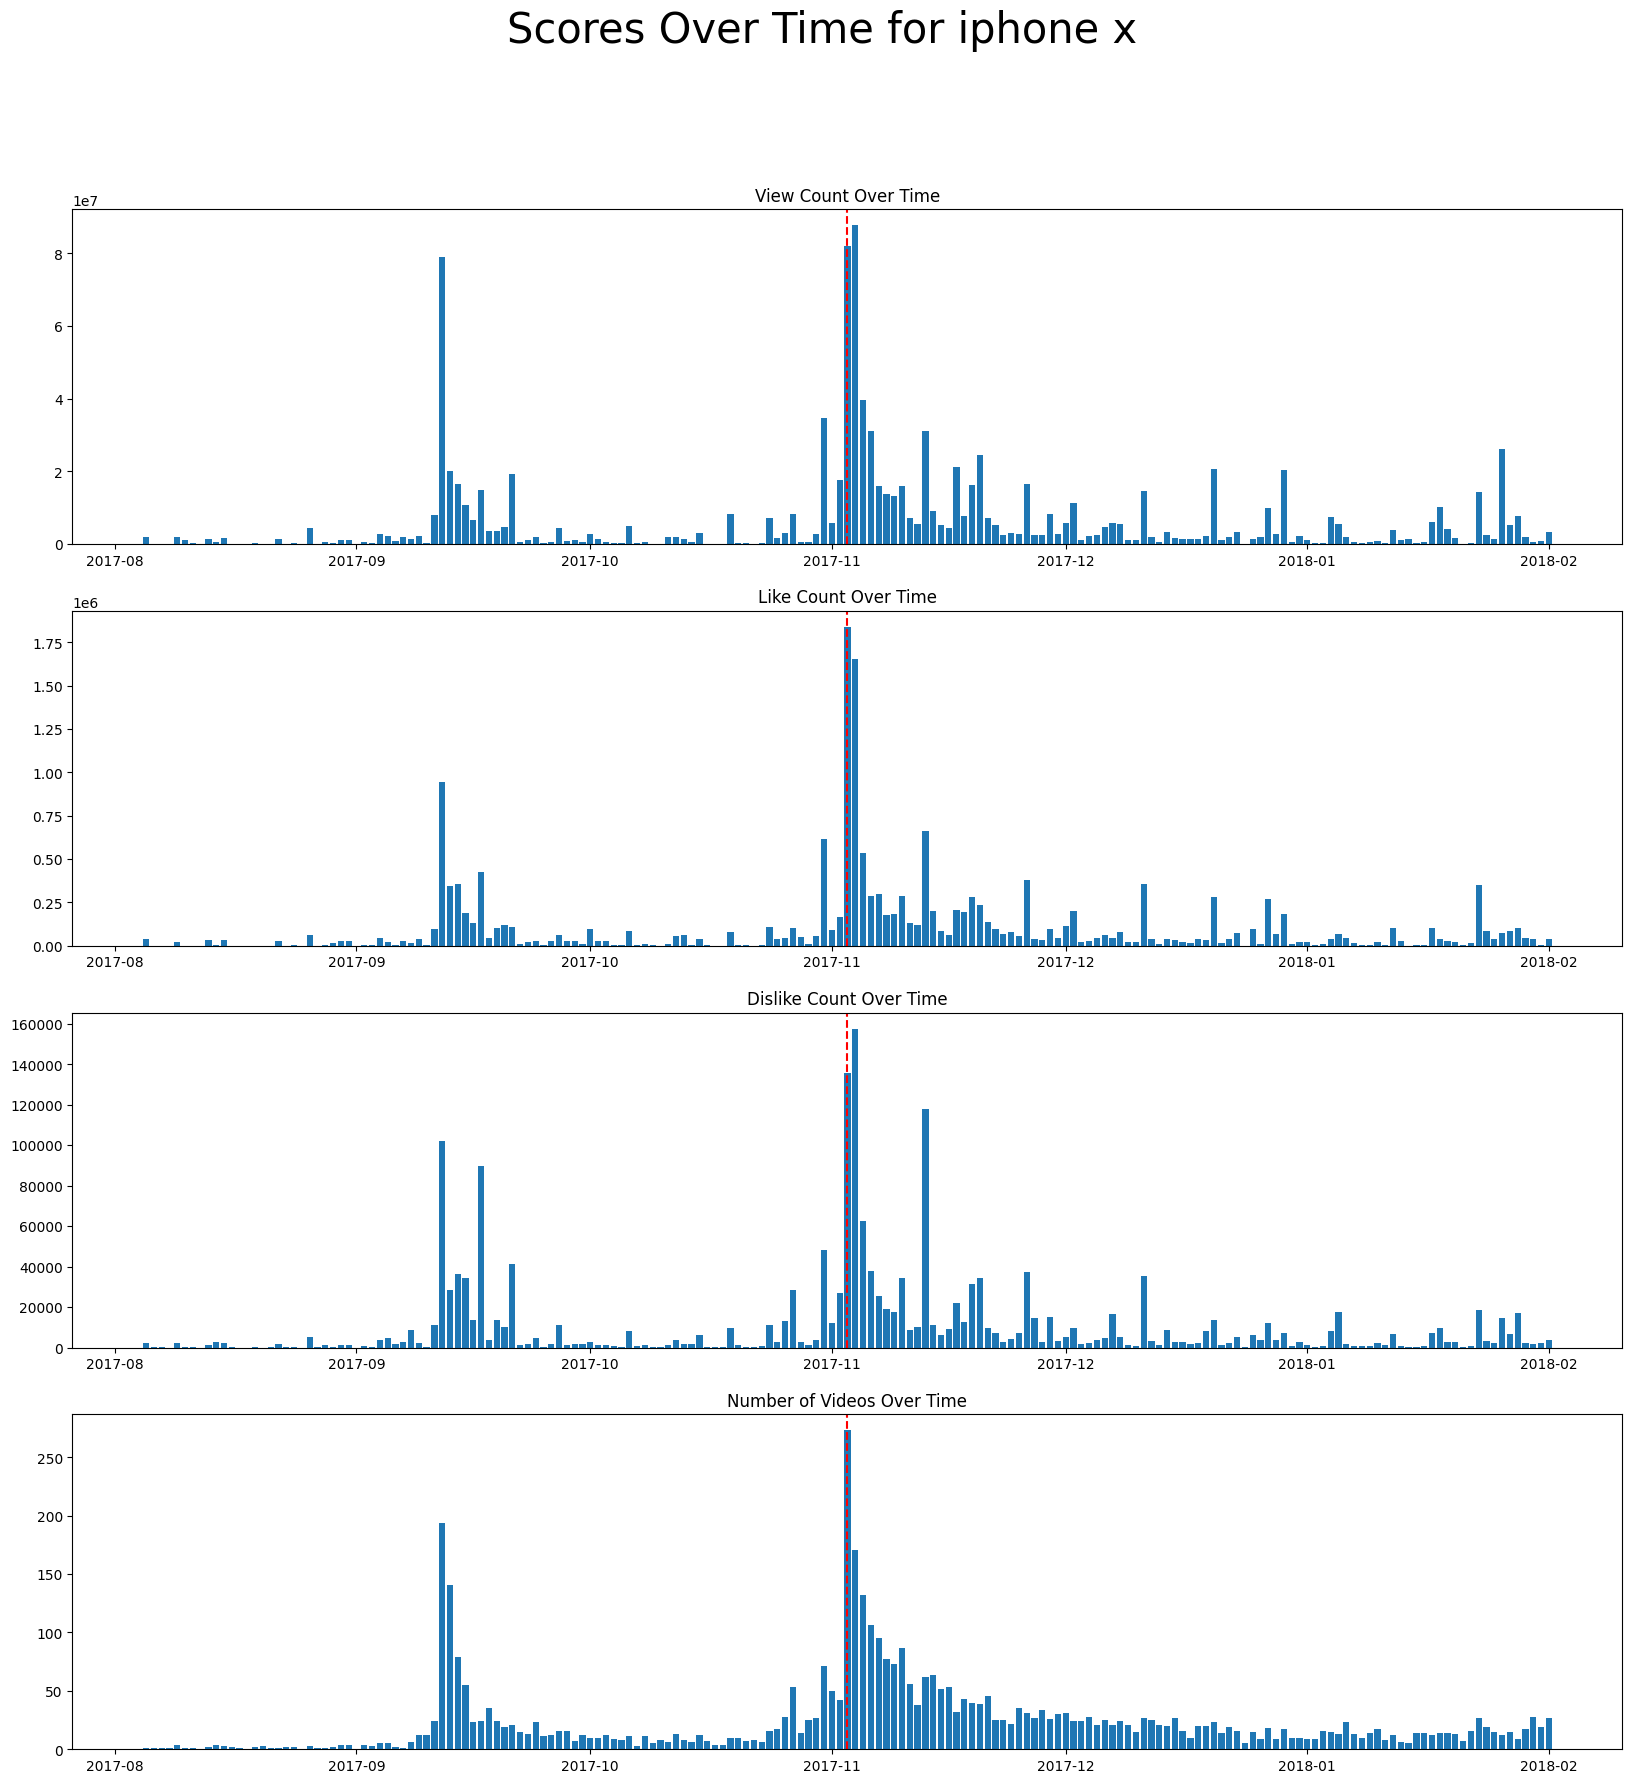

In [32]:
# convert RELEASE_DATES['iphone x'] to datetime
release_date = datetime.datetime.strptime(RELEASE_DATES['iphone x'], '%Y-%m-%d').date()
plot_scores(df, release_date, 'iphone x')